In [1]:
pip install torchaudio datasets transformers==4.48.0 accelerate torch soundfile SentencePiece matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import zipfile

# Specify the path to your zip file
zip_file = 'wavs1.zip'
# Specify the destination directory where you want to extract the contents
destination_dir = ''

# Extract the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print(f"Files extracted to {destination_dir}")

Files extracted to 


In [49]:
import pandas as pd
df = pd.read_csv("metadata1.csv", sep='|', names = ["ID","sentence","normalized_sentence"])
# df['ID'] = df['ID'].apply(lambda x: f'{x:03}' if x < 1000 else str(x))
df = df[["ID","normalized_sentence"]]
df

,ID,normalized_sentence
0,LJ001-0001,"Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...
...,...,...
13095,LJ050-0274,made certain recommendations which it believes...
13096,LJ050-0275,materially improve upon the procedures in effe...
13097,LJ050-0276,"As has been pointed out, the Commission has no..."
13098,LJ050-0277,with the active cooperation of the responsible...


In [50]:
df.isna().sum()
df.dropna(inplace=True)
df = df.drop(index=0).reset_index(drop=True)
df

,ID,normalized_sentence
0,LJ001-0002,in being comparatively modern.
1,LJ001-0003,For although the Chinese took impressions from...
2,LJ001-0004,"produced the block books, which were the immed..."
3,LJ001-0005,the invention of movable metal letters in the ...
4,LJ001-0006,"And it is worth mention in passing that, as an..."
...,...,...
13078,LJ050-0274,made certain recommendations which it believes...
13079,LJ050-0275,materially improve upon the procedures in effe...
13080,LJ050-0276,"As has been pointed out, the Commission has no..."
13081,LJ050-0277,with the active cooperation of the responsible...


In [51]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)
dataset

Dataset({
    features: ['ID', 'normalized_sentence'],
    num_rows: 13083
})

In [52]:
import torchaudio
import torchaudio.transforms as T
import os
WAVS_DIR = "wavs"

resampler = T.Resample(new_freq=16000)

def load_audio(example):
    wav_path = os.path.join(WAVS_DIR, f"{example['ID']}.wav")
    waveform, sr = torchaudio.load(wav_path)
    if sr != 16000:
        waveform = resampler(waveform)

    example["audio"] = waveform.squeeze().numpy()  # just the array, no sampling rate
    return example

dataset = dataset.map(load_audio)

Map:   0%|          | 0/13083 [00:00<?, ? examples/s]

In [53]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)
tokenizer = processor.tokenizer


In [54]:
def extract_all_chars(batch):
    # Filter out None values or replace with empty string
    all_text = " ".join([sentence if sentence is not None else "" for sentence in batch["normalized_sentence"]])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map:   0%|          | 0/13083 [00:00<?, ? examples/s]

In [55]:
dataset_vocab - tokenizer_vocab

{' ', 'à', 'â', 'è', 'ü', '’', '“', '”'}

In [56]:
# Updated replacement rules
replacements = [
    ("à", "a"),
    ("â", "a"),
    ("è", "e"),  # already handled
    ("ü", "u"),
    ("’", "'"),
    ("“", '"'),
    ("”", '"'),
    ("$", "dollar sign"),
]

# Mapping digits to words
digit_to_word = {
    "0": "zero",
    "1": "one",
    "2": "two",
    "3": "three",
    "4": "four",
    "5": "five",
    "6": "six",
    "7": "seven",
    "8": "eight",
    "9": "nine",
}

def cleanup_text(inputs):
    text = inputs.get("normalized_sentence")
    if text is not None:
        # Apply character replacements
        for src, dst in replacements:
            text = text.replace(src, dst)
        
        # Replace digits with words
        for digit, word in digit_to_word.items():
            text = text.replace(digit, f" {word} ")  # Add spaces to prevent sticking to words

        # Optional: Normalize whitespace (e.g., multiple spaces → one)
        text = " ".join(text.split())

        # Update the input dictionary
        inputs["normalized_sentence"] = text
    return inputs

# Apply cleanup_text function to dataset
dataset = dataset.map(cleanup_text)


Map:   0%|          | 0/13083 [00:00<?, ? examples/s]

In [57]:
!pip install speechbrain


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [58]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

In [59]:
def prepare_dataset(example):
    audio_array = example["audio"]
    sampling_rate = 16000  # or whatever your actual sampling rate is

    example = processor(
        text=example["normalized_sentence"],
        audio_target=audio_array,
        sampling_rate=sampling_rate,
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]
    example["speaker_embeddings"] = create_speaker_embedding(audio_array)

    return example

processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())


['input_ids', 'labels', 'speaker_embeddings']

In [60]:
processed_example["speaker_embeddings"].shape


(512,)

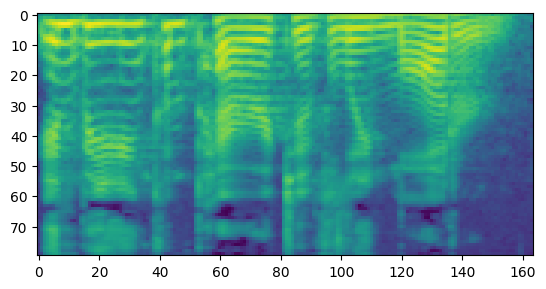

In [61]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [62]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

Map:   0%|          | 0/13083 [00:00<?, ? examples/s]

In [63]:
# def is_not_too_long(input_ids):
#     input_length = len(input_ids)
#     return input_length < 200


# dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
# len(dataset)

In [64]:
example = dataset[9]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [65]:
speaker_embeddings

tensor([[-7.7735e-02,  6.0888e-02,  4.3054e-02,  2.9000e-02,  3.1763e-02,
          2.1259e-02, -4.0531e-02, -1.9594e-03,  2.8220e-02,  1.4145e-02,
         -7.0816e-02, -7.3973e-02,  6.8163e-02,  3.8573e-02,  4.2987e-02,
          4.0687e-02,  1.5862e-02,  3.1072e-02,  9.2235e-03,  2.0728e-02,
          2.9989e-02,  1.9954e-02, -1.3240e-02, -4.9654e-02, -7.0974e-02,
         -8.8211e-03, -6.1323e-02, -2.9342e-02,  4.1136e-02,  4.2263e-02,
         -3.2501e-03,  5.0494e-02,  2.5433e-02, -1.6476e-02,  4.5807e-02,
         -5.9550e-02,  3.1316e-02,  6.2177e-02, -1.2639e-02, -7.5495e-02,
          1.1206e-02, -1.4976e-02,  4.2492e-02,  2.8965e-02,  2.7012e-02,
         -1.0714e-01, -1.7577e-02,  1.2352e-02, -7.4576e-02,  1.7533e-02,
          2.8818e-02,  3.0891e-02,  2.8733e-02,  3.0073e-02, -9.2180e-02,
         -3.4045e-02,  2.9227e-02,  2.9264e-02,  3.8078e-02,  3.5094e-03,
          2.3465e-02, -6.5242e-03, -1.3329e-02,  9.7612e-03,  1.9906e-02,
          5.6998e-02,  2.3596e-02, -3.

In [79]:
tokenized_dataset = dataset.train_test_split(test_size=0.1)
    

In [80]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch
data_collator = TTSDataCollatorWithPadding(processor=processor)


In [81]:
from transformers import SpeechT5ForTextToSpeech
from functools import partial

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)


# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [82]:
# from transformers import Seq2SeqTrainingArguments
# os.environ["WANDB_DISABLED"] = "true"

# training_args = Seq2SeqTrainingArguments(
#     output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
#     per_device_train_batch_size=4,
#     gradient_accumulation_steps=8,
#     learning_rate=1e-5,
#     warmup_steps=500,
#     max_steps=4000,
#     gradient_checkpointing=True,
#     fp16=True,
#     eval_strategy="steps",
#     per_device_eval_batch_size=2,
#     save_steps=1000,
#     eval_steps=10,
#     logging_steps=25,
#     # report_to=["tensorboard"],
#     load_best_model_at_end=True,
#     greater_is_better=False,
#     label_names=["labels"],
#     # push_to_hub=True,
# )

In [ ]:
# from transformers import Seq2SeqTrainingArguments
from transformers import Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    num_train_epochs=50,
    warmup_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_eval_batch_size=16,
    eval_steps=1,
    save_steps=50,
    logging_steps=1000,
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
)


trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_6018/1485598227.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,No log,0.387632
2,No log,0.383573
3,0.422300,0.380689
4,0.422300,0.376868
5,0.422300,0.376223
6,0.411600,0.374317


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [ ]:
trainer.save_model("/workspace/model2") 
tokenizer.save_pretrained("/workspace/model2") 